# モジュール

In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from time import sleep
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

# モデルの定義

## Generator
なんてことないベーシックなGenerator

In [1]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

NameError: ignored

## Discriminator
VDB要素がある。処理自体はVAEのDecoderとEncoderの間と同じ。

1. 入力画像を畳み込み => x
2. xを２つ畳み込み => mean, logvar
3. 標準正規分布からmeanと同じサイズのランダム出力 => noize
4. 潜在変数を次の式から算出 $noize\times e^{\frac{logvar}{2}}+mean$ => z
5. 全結合層にzを入力 => x'

出力：x', mean, logvar


In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1x28x28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # -> 64x14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- VDB
        self.conv_mean = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        self.conv_logvar = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        # --------------------------------
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- VDB
        mean = self.conv_mean(x).view(-1, 128 * 7 * 7) # mean
        logvar = self.conv_logvar(x).view(-1, 128 * 7 * 7) # logvar
        noise = torch.randn(mean.size(), device=device)
        z = (0.5 * logvar).exp() * noise + mean
        # --------------------------------
        
        x = self.fc(z)
        return x, mean, logvar

## 重みの初期化

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 学習訓練

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta):

    y_real = torch.ones(batch_size, 1)
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        # 学習モードに切り替え
        D.train()  
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)
        
        # ----------------------------------------------------------------
        # Discriminator update
        # ----------------------------------------------------------------
        D_optimizer.zero_grad()

        # D train on real images
        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        # D train on fake images
        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetach?
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- VDB
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- 
        
        # ----------------------------------------------------------------
        # Generator update
        # ----------------------------------------------------------------
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images)
        G_loss = G_criterion(D_fake, y_real)
        
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, beta

In [ ]:
def generate(G):
    G.eval()

    sample_z = torch.rand((25, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        images = G(sample_z).to('cpu')
        plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
        plt.axis('off')
        plt.show()

In [ ]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs/vgan-mnist'

In [ ]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(-0.5, 145.5, 145.5, -0.5)

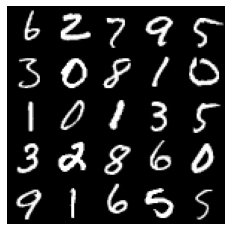

In [ ]:
images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
plt.axis('off')

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- VDB
I_c = 0.1
beta = 0 #1.0
alpha = 1e-5

def VDB_loss(out, label, mean, logvar, beta):
    normal_D_loss = torch.mean(F.binary_cross_entropy(out, label))
    
    kldiv_loss = - 0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
# --------------------------------

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

100%|██████████| 468/468 [00:40<00:00, 11.54it/s]


epoch 1, D_loss: 1.3925 G_loss: 0.6965


100%|██████████| 468/468 [00:40<00:00, 11.57it/s]


epoch 2, D_loss: 1.3878 G_loss: 0.6940


100%|██████████| 468/468 [00:40<00:00, 11.58it/s]


epoch 3, D_loss: 1.3869 G_loss: 0.6936


100%|██████████| 468/468 [00:40<00:00, 11.58it/s]


epoch 4, D_loss: 1.3472 G_loss: 0.7269


100%|██████████| 468/468 [00:40<00:00, 11.60it/s]


epoch 5, D_loss: 1.2007 G_loss: 0.8883


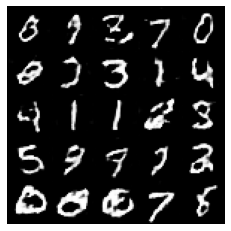

100%|██████████| 468/468 [00:40<00:00, 11.59it/s]


epoch 6, D_loss: 1.1338 G_loss: 0.9967


100%|██████████| 468/468 [00:40<00:00, 11.59it/s]


epoch 7, D_loss: 1.0905 G_loss: 1.0685


100%|██████████| 468/468 [00:40<00:00, 11.61it/s]


epoch 8, D_loss: 1.0651 G_loss: 1.1175


100%|██████████| 468/468 [00:40<00:00, 11.64it/s]


epoch 9, D_loss: 1.0500 G_loss: 1.1548


100%|██████████| 468/468 [00:40<00:00, 11.66it/s]


epoch 10, D_loss: 1.0430 G_loss: 1.1861


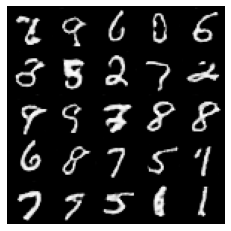

100%|██████████| 468/468 [00:40<00:00, 11.56it/s]


epoch 11, D_loss: 1.0322 G_loss: 1.2087


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


epoch 12, D_loss: 1.0207 G_loss: 1.2438


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


epoch 13, D_loss: 1.0161 G_loss: 1.2528


100%|██████████| 468/468 [00:40<00:00, 11.58it/s]


epoch 14, D_loss: 1.0103 G_loss: 1.2818


100%|██████████| 468/468 [00:40<00:00, 11.63it/s]


epoch 15, D_loss: 1.0102 G_loss: 1.2971


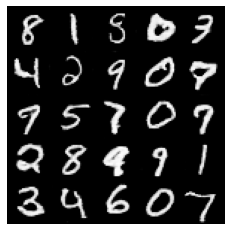

100%|██████████| 468/468 [00:40<00:00, 11.53it/s]


epoch 16, D_loss: 1.0059 G_loss: 1.3095


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


epoch 17, D_loss: 0.9974 G_loss: 1.3201


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


epoch 18, D_loss: 0.9987 G_loss: 1.3450


100%|██████████| 468/468 [00:40<00:00, 11.52it/s]


epoch 19, D_loss: 0.9979 G_loss: 1.3558


100%|██████████| 468/468 [00:40<00:00, 11.56it/s]


epoch 20, D_loss: 0.9923 G_loss: 1.3624


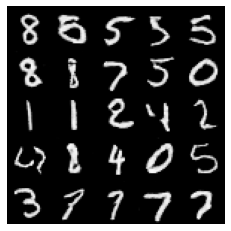

100%|██████████| 468/468 [00:40<00:00, 11.53it/s]


epoch 21, D_loss: 0.9827 G_loss: 1.3795


100%|██████████| 468/468 [00:40<00:00, 11.47it/s]


epoch 22, D_loss: 0.9913 G_loss: 1.3799


100%|██████████| 468/468 [00:40<00:00, 11.53it/s]


epoch 23, D_loss: 0.9817 G_loss: 1.3938


100%|██████████| 468/468 [00:40<00:00, 11.54it/s]


epoch 24, D_loss: 0.9738 G_loss: 1.4040


100%|██████████| 468/468 [00:40<00:00, 11.52it/s]


epoch 25, D_loss: 0.9760 G_loss: 1.4264


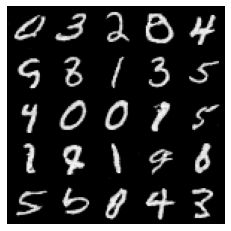

In [ ]:
history = {}
history['D_loss'] = []
history['G_loss'] = []

for epoch in range(num_epochs):
    D_loss, G_loss, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # show
    if (epoch+1) % 5 == 0:
      generate(G)
    sleep(0.5) # for tqdm(?)

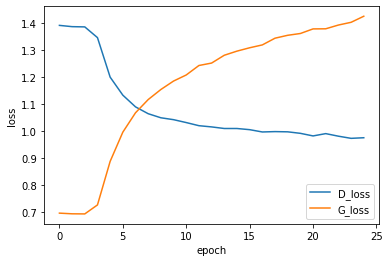

In [ ]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()